In [1]:
from __future__ import print_function
import numpy as np    
import csv
import copy
import pandas as pd
import random
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, ExpSineSquared
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from scipy.stats import norm
from sklearn.preprocessing import normalize



In [2]:


##  Read Data  ##

ifile  = open('Data.csv', "rt")
reader = csv.reader(ifile)
csvdata=[]
for row in reader:
        csvdata.append(row)   
ifile.close()
numrow=len(csvdata)
numcol=len(csvdata[0]) 
csvdata = np.array(csvdata).reshape(numrow,numcol)
Sys = csvdata[:,0]
Atom_A = csvdata[:,1]
Atom_B = csvdata[:,2]
Struct = csvdata[:,3]
Vol_pfu = csvdata[:,4]
Delta_H = csvdata[:,5]
Gap = csvdata[:,6]
X = csvdata[:,7:]

    # Read Outside Data
#ifile  = open('Outside.csv', "rt")
#reader = csv.reader(ifile)
#csvdata=[]
#for row in reader:
#        csvdata.append(row)
#ifile.close()
#numrow=len(csvdata)
#numcol=len(csvdata[0])
#csvdata = np.array(csvdata).reshape(numrow,numcol)
#Sys_out = csvdata[:,0]
#Atom_A_out = csvdata[:,1]
#Atom_B_out = csvdata[:,2]
#X_out = csvdata[:,3:]

#n_out = Sys_out.size


X_fl = np.array(X, dtype="float32")
X_norm = normalize(X_fl, norm='l2', axis=0)

Prop = copy.deepcopy(Delta_H)
n = Sys.size
m = int(X.size/n)

t = 0.50

X_train, X_test, Prop_train, Prop_test, Atom_A_train, Atom_A_test, Atom_B_train, Atom_B_test  =  train_test_split(X_norm, Prop, Atom_A, Atom_B, test_size=t)

n_tr = Prop_train.size
n_te = Prop_test.size

X_train_fl = np.array(X_train, dtype="float32")
X_test_fl = np.array(X_test, dtype="float32")
Prop_train_fl = np.array(Prop_train, dtype="float32")
Prop_test_fl = np.array(Prop_test, dtype="float32")



In [5]:


###  GPR Definition  ###

ker_dp = C(1.0, (1e-3, 1e3)) * DotProduct(2)
ker_rbf = C(1.0, (1e-5, 1e5)) * RBF(10, (1e-5, 1e5))
ker_rq = C(1.0, (1e-5, 1e5)) * RationalQuadratic(alpha=0.1, length_scale=10, length_scale_bounds=(1e-5, 1e5))
ker_expsine = C(1.0, (1e-5, 1e5)) * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
ker_matern = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e4), nu=1.5)

ker_rbf = C(1.0) * RBF(10)

param_grid = {
#"kernel": [ker_matern, ker_rbf, ker_rq, ker_dp, ker_expsine],
"kernel": [ker_expsine],
#"alpha": [1e0, 1e-1, 1e-2, 1e-3],
"alpha": [1e-1],
"optimizer": ['fmin_l_bfgs_b'],
#"n_restarts_optimizer": [50, 100, 200]
"n_restarts_optimizer": [50]
}




  ##  Train Gaussian Process Regression Model  ##

gpr_opt = GridSearchCV(GaussianProcessRegressor(normalize_y=False), param_grid=param_grid, cv=5)
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#gpr_opt = GaussianProcessRegressor(kernel=ker_expsine, alpha=0.1, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=50)

gpr_opt.fit(X_train_fl, Prop_train_fl)
Pred_train, sigma_train = gpr_opt.best_estimator_.predict(X_train_fl, return_std=True)
Pred_test, sigma_test  = gpr_opt.best_estimator_.predict(X_test_fl, return_std=True)

Pred_train_fl = np.array(Pred_train, dtype="float32")
Pred_test_fl = np.array(Pred_test, dtype="float32")
sigma_train_fl = np.array(sigma_train, dtype="float32")
sigma_test_fl = np.array(sigma_test, dtype="float32")


## Outside Predictions

#Pred_out, sigma_out = gpr_opt.best_estimator_.predict(X_out_fl, return_std=True)
#Pred_out_fl = np.array(Pred_out, dtype="float32")
#sigma_out_fl = np.array(sigma_out, dtype="float32")


mse_test = sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl)
mse_train = sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mse_train)
print('rmse_test_DH = ', np.sqrt(mse_test))
print('rmse_train_DH = ', np.sqrt(mse_train))
print('      ')





/Users/amannodi/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


rmse_test_DH =  0.9692254
rmse_train_DH =  0.23153698
      


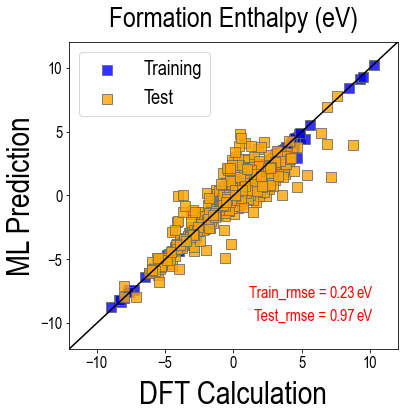

In [6]:


## ML Parity Plots ##

fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.19, bottom=0.17, right=0.95, top=0.88, wspace=0.25, hspace=0.4)
plt.rc('font', family='Arial narrow')
plt.rcParams.update({'font.size': 16})

plt.ylabel('ML Prediction', fontname='Arial Narrow', size=32)
plt.xlabel('DFT Calculation', fontname='Arial Narrow', size=32, labelpad=10)

a = [-175,0,125]
b = [-175,0,125]
plt.plot(b, a, c='k', ls='-')

plt.scatter(Prop_train_fl[:], Pred_train_fl[:], c='blue', marker='s', s=100, edgecolors='dimgrey', alpha=0.8, label='Training')
plt.scatter(Prop_test_fl[:], Pred_test_fl[:], c='orange', marker='s', s=100, edgecolors='dimgrey', alpha=0.8, label='Test')

#plt.errorbar(Prop_train_fl[:], Pred_train_fl[:], yerr = [err_up_train[:]-Pred_train_fl[:], Pred_train_fl[:]-err_down_train[:]], c='blue', marker='s', markeredgecolor='dimgrey', markersize=10, fmt='o', ecolor='blue', capthick=2, label='Training')
#plt.errorbar(Prop_test_fl[:], Pred_test_fl[:], yerr =  [err_up_test[:]-Pred_test_fl[:], Pred_test_fl[:]-err_down_test[:]], c='orange', marker='s', markeredgecolor='dimgrey', markersize=10, fmt='o', ecolor='orange', capthick=2, label='Test')

te = '%.2f' % rmse_test
tr = '%.2f' % rmse_train

plt.text(1.15, -8.0, 'Train_rmse = ', color='r', fontsize=16)
plt.text(7.0, -8.0, tr, color='r', fontsize=16)
plt.text(9.0, -8.0, 'eV', color='r', fontsize=16)
plt.text(1.5, -9.8, 'Test_rmse = ', color='r', fontsize=16)
plt.text(7.0, -9.8, te, color='r', fontsize=16)
plt.text(9.0, -9.8, 'eV', color='r', fontsize=16)

plt.ylim([-12, 12])
plt.xlim([-12, 12])
plt.xticks([-10, -5, 0, 5, 10])
plt.yticks([-10, -5, 0, 5, 10])

plt.title('Formation Enthalpy (eV)', color='k', fontsize=28, pad=15)
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':20})
plt.rc('xtick', c='k', labelsize=24)
plt.rc('ytick', c='k', labelsize=24)

plt.savefig('plot.pdf', dpi=450)
#plt.show()


